In [2]:
%matplotlib notebook

import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import sklearn.linear_model as lin

In [3]:
# plt.ioff()
np.random.seed(0)

points = 9
coefs = [-2,4,3]
f = np.poly1d(coefs)

XTrain = np.linspace(-4,4,points)
YTrain = f(XTrain) + rnd.normal(scale=10,size=points)

XTest = np.linspace(-5,5,points)
YTest = f(XTest) + rnd.normal(scale=10,size=points)

We are going to fit a polynomial using linear regression

In [4]:
# evaluates polynomial(x)
def polynomial(coefs,x):
    degree = len(coefs)
    y = 0
    for i in range(degree):
        y += coefs[degree-i-1] * x**i
    return y
    
# plots any polynomial
def plot_polynomial(coefs,color='blue'):
    xs = np.linspace(-5,5,101)
    plt.plot(xs,polynomial(coefs,xs),color=color)

# plots the actual polynomial that our model is trying to fit
def plot_actual():
    plot_polynomial(coefs,color='green')

# plot points
def plot_points(X,Y,color='blue'):
    plt.scatter(X,Y,color=color)

The problem is that we only have 1 feature. We cannot model a polynomial with degree higher than 2 such as $x^2 - x + 1$ with only $x$ as its feature. We can solve this by using a basis function to convert a single feature into multiple features. The basis function we will use is called a polynomial basis. It returns an array of features such that $[x^n, x^{n-1}, ...,x^2, x, 1]$. With this, we can represent any polynomials as a linear combination of the new feature space.

In [5]:
# returns an array[x^degree, x^(degree-1), ..., x^0]
def basis_function(x, degree):
    basis = [pow(x,i) for i in range(9)]
    basis[degree+1:] = [0] * (8-degree)
    return basis[::-1]

# returns a 2d array s.t. each row is basis_function(x)
def basis_functions(xs,degree):
    return np.asarray([basis_function(x,degree) for x in xs])

Now let us fit our model to the training data with a varying number of degrees

<IPython.core.display.Javascript object>


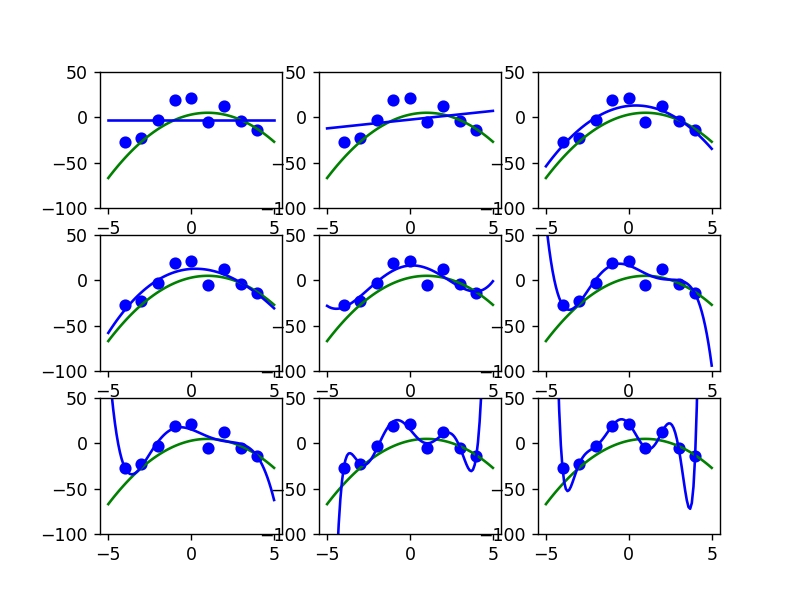

degree: 0, theta: [ 0.          0.          0.          0.          0.          0.
  0.          0.         -2.58929644]
degree: 1, theta: [ 0.          0.          0.          0.          0.          0.
  0.          1.93348362 -2.58929644]
degree: 2, theta: [ 0.          0.          0.          0.          0.          0.
 -2.28158326  1.93348362 12.62125866]
degree: 3, theta: [ 0.          0.          0.          0.          0.          0.05938374
 -2.28158326  1.2327555  12.62125866]
degree: 4, theta: [ 0.          0.          0.          0.          0.12179009  0.05938374
 -4.28242052  1.2327555  16.37935298]
degree: 5, theta: [ 0.          0.          0.         -0.09769412  0.12179009  2.06754057
 -4.28242052 -6.53935417 16.37935298]
degree: 6, theta: [ 0.00000000e+00  0.00000000e+00  8.11145401e-03 -9.76941160e-02
 -7.36222073e-02  2.06754057e+00 -3.16598949e+00 -6.53935417e+00
  1.54944671e+01]
degree: 7, theta: [ 0.00000000e+00  4.57292822e-02  8.11145401e-03 -1.32886710e+00
 

In [6]:
plt.figure()

thetas =  []

reg = lin.LinearRegression()
for degree in range(9):
    basis = basis_functions(XTrain,degree)
    reg = reg.fit(basis,YTrain)
    theta = reg.coef_
    theta[8] = reg.intercept_
    theta[:8-degree]=0

    thetas.append(theta)
    plt.subplot(3,3,degree+1)
    plot_actual()
    plot_points(XTrain,YTrain)
#     plot_points(XTest,YTest,color='orange')
    plot_polynomial(theta)
    plt.ylim(-100,50)
    print(f"degree: {degree}, theta: {theta}")
    
plt.show()

note: blue points are the training data given to the model, but there are some noise that causes it to be distributed around randomly, green line is the true polynomial that we are trying to fit, blue line is the polynomial that the model has predicted.

The top left graph is a polynomial with degree 0, i.e. a horizontal line with a bias. As we can see, it is too simple and unable to capture the underlying data structure (underfitting).

The bottom left graph is a polynomial with degree 8, it fits the training data perfectly with no error. However, it seems like it is too wavy and not able to capture the actual structure (overfitting). 

Let us plot the loss function for each of the degrees.

<IPython.core.display.Javascript object>


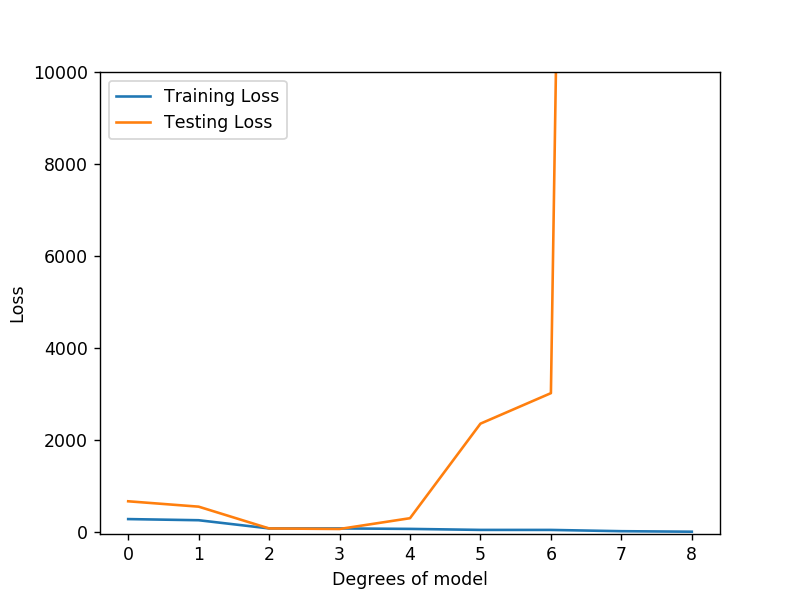

Training losses:  [274.4792269293294, 249.55683408912535, 71.40887465567356, 70.85028838291277, 61.15385750797694, 39.09628882132552, 38.66562614860405, 11.14995970148802, 7.449491601471105e-23]
Test losses:  [661.6967671420804, 544.7309814162351, 70.9556733303932, 58.99936434033768, 293.5933945977167, 2350.416107930956, 3013.9225969354934, 101475.57433589664, 1186062.5090817416]


In [7]:
# plots the loss function of training data and testing data vs degree

# returns the loss of our model
def loss_function(W,X,Y):
    prediction = np.matmul(basis_functions(X,9),W.T)
    loss = (prediction - Y)**2
    return np.mean(loss)

trainLosses = []
testLosses = []
for degree in range(9):
    trainLoss = loss_function(thetas[degree],XTrain,YTrain)
    trainLosses.append(trainLoss)
    testLoss = loss_function(thetas[degree],XTest,YTest)
    testLosses.append(testLoss)
    
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Degrees of model")
plt.plot(np.arange(9),trainLosses,label='Training Loss')
plt.plot(np.arange(9),testLosses,label='Testing Loss')
plt.ylim(-50,10000)
plt.legend()
plt.show()

print("Training losses: ",trainLosses)
print("Test losses: ", testLosses)

Let us try to plot the testing loss (loss on unseen data). The training loss is (nearly) 0 when the degrees of model is 8, and it has a testing loss  is 1.1 million, we couldnt even see other losses unless we limit our yaxis. 

So why does the last model fit training data so well but so poorly on unseen data? This is because it has 9 features, so 9 parameters it can tune to fit the 9 training data perfectly. However, it only memorized the training data, its memory does not generalize well to unseen data.

How do we reduce overfitting? We can train with more data, remove unnecessary features, early stopping, regularation or cross validation.

Below here, we will demonstrate regularization.

In a normal gradient descent algorithm, the loss function is 
$$L(x) = \frac{1}{n} \sum^N_{i=1} \left(y^{(i)} - f(x^{(i)})\right)^2 $$
In a regularized gradient descent algorithm, so the loss function is 
$$L(x) = \frac{1}{n} \sum^N_{i=1} \left(y^{(i)} - f(x^{(i)})\right)^2 + \alpha \sum_j \theta_j^2$$
We want to penalize large weights, as it usually indicates that our model has overfitted the training data. We use $\alpha$ to show the importance of the regularization term.

<IPython.core.display.Javascript object>


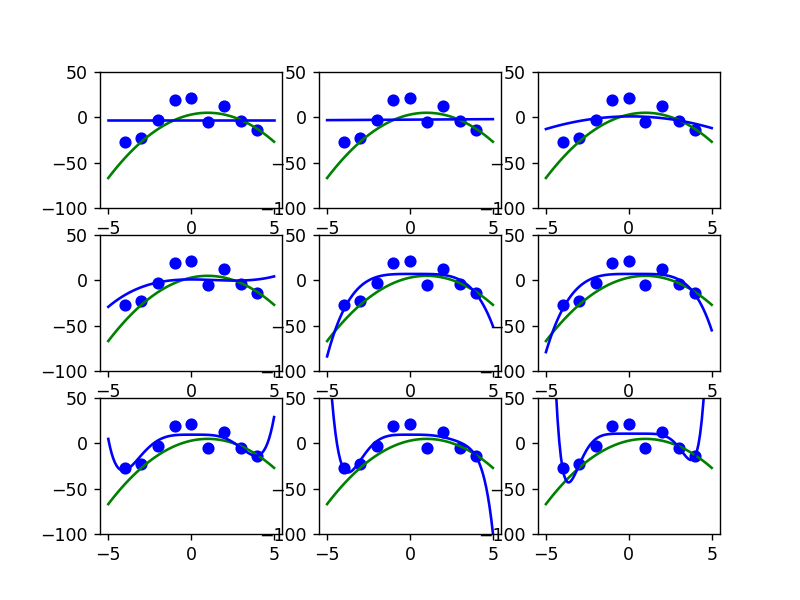

degree: 0, weight: [ 0.          0.          0.          0.          0.          0.
  0.          0.         -2.58929644]
degree: 1, weight: [ 0.          0.          0.          0.          0.          0.
  0.          0.10944247 -2.58929644]
degree: 2, weight: [ 0.          0.          0.          0.          0.          0.
 -0.53725355  0.10944247  0.9923939 ]
degree: 3, weight: [ 0.          0.          0.          0.          0.          0.13350771
 -0.53725355  0.02026939  0.9923939 ]
degree: 4, weight: [ 0.          0.          0.          0.         -0.11513439  0.13350771
 -0.09185599  0.02026939  7.08031548]
degree: 5, weight: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.26533007e-03
 -1.15134390e-01  1.77282280e-01 -9.18559884e-02  2.11585768e-02
  7.08031548e+00]
degree: 6, weight: [ 0.00000000e+00  0.00000000e+00  1.47024341e-02 -3.26533007e-03
 -3.53163033e-01  1.77282280e-01 -6.47429893e-02  2.11585768e-02
  9.64783702e+00]
degree: 7, weight: [ 0.00000000e+00 -4.7

In [11]:
plt.figure()

ridge = lin.Ridge(1000)
regThetas = []
for degree in range(9):
    basis = basis_functions(XTrain,degree)
    ridge.fit(basis,YTrain)
    theta = ridge.coef_
    theta[8] = ridge.intercept_
    regThetas.append(theta)
    plt.subplot(3,3,degree+1)
    plot_actual()
    plot_points(XTrain,YTrain)
#     plot_points(XTest,YTest,color='orange')
    plot_polynomial(theta)
    plt.ylim(-100,50)
    print(f"degree: {degree}, weight: {theta}")
plt.show()

<IPython.core.display.Javascript object>


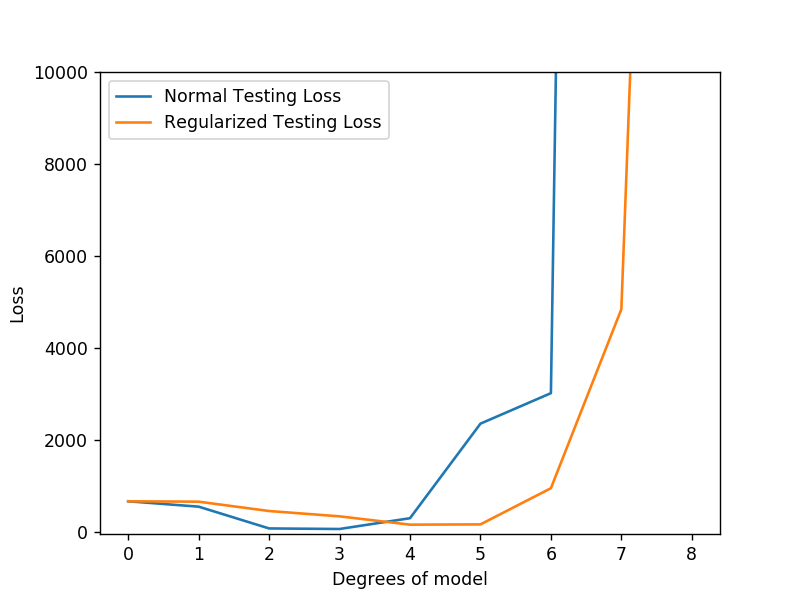

In [10]:
# print(regThetas)

regTestLosses = []
regTrainLosses = []
for degree in range(9):
    trainLoss = loss_function(regThetas[degree],XTrain,YTrain)
    regTrainLosses.append(trainLoss)
    testLoss = loss_function(regThetas[degree],XTest,YTest)
    regTestLosses.append(testLoss)

plt.figure()
plt.ylabel("Loss")
plt.xlabel("Degrees of model")
plt.plot(np.arange(9), testLosses,label='Normal Testing Loss')
plt.plot(np.arange(9), regTestLosses,label='Regularized Testing Loss')
# plt.plot(np.arange(9), trainLosses,label='Normal Training Loss')
# plt.plot(np.arange(9), regTrainLosses,label='Regularized Training Loss')
plt.ylim(-50,10000)
plt.legend()
plt.show()